In [30]:
import os
import rasterio
import numpy as np
from glob import glob

# Set input and output directories
input_dir = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\hlswater\13QGC\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0"
output_dir = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Band definitions
sentinel_bands = ['B02', 'B03', 'B04', 'B05', 'B07']
swir_band = 'B07'

# Find all images in the folder
band_files = {band: None for band in sentinel_bands}
for band in sentinel_bands:
    for filepath in glob(os.path.join(input_dir, f"*{band}.TIF")):
        band_files[band] = filepath

# Check that all bands were found
missing_bands = [band for band, filepath in band_files.items() if filepath is None]
if missing_bands:
    raise FileNotFoundError(f"Missing bands: {', '.join(missing_bands)}")

# Read SWIR band (B12)
with rasterio.open(band_files[swir_band]) as src:
    swir_data = src.read(1) / 10000.0
    profile = src.profile

# Process each band
for band, filepath in band_files.items():
    if band == swir_band:
        continue  # Skip SWIR band itself
    
    # Read the band
    with rasterio.open(filepath) as src:
        band_data = src.read(1) / 10000.0

        # Subtract SWIR from the band
        result = band_data - swir_data

        # Update profile for output
        profile.update(dtype=rasterio.float32, count=1)

        # Save the new image
        output_file = os.path.join(output_dir, f"{band}_glint.TIF")
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(result.astype(rasterio.float32), 1)

        print(f"Saved: {output_file}")


Saved: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint\B02_glint.TIF
Saved: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint\B03_glint.TIF
Saved: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint\B04_glint.TIF
Saved: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint\B05_glint.TIF


In [6]:
import numpy as np
import rasterio
import os
from rasterio.mask import mask
import geopandas as gpd
from scipy.ndimage import median_filter
from sklearn.linear_model import LinearRegression

def calculate_mndwi(green_band, swir_band):

    mndwi = (green_band - swir_band) / (green_band + swir_band)
    
    return mndwi

def apply_glint_correction(input_bands, green_band, swir_band, output_dir, mndwi_threshold=0.45):

    with rasterio.open(green_band) as green_src, rasterio.open(swir_band) as swir_src:
        green = green_src.read(1).astype(np.float32)/ 10000.0
        swir = swir_src.read(1).astype(np.float32)/ 10000.0
        profile = green_src.profile
        
        filtered_swir = median_filter(swir, size=3)
        
        # Calculate MNDWI
        mndwi = calculate_mndwi(green, swir)

        # Define ROI where MNDWI > threshold
        roi_mask = mndwi > mndwi_threshold
        roi_indices = np.where(roi_mask)

        # Calculate beta (minimum SWIR value in ROI)
        beta = np.min(swir[roi_mask])

        # Perform linear regression to calculate alpha (slope)
        regression = LinearRegression()
        swir_roi = swir[roi_mask].reshape(-1, 1)  # SWIR values in ROI
        
        for band_path in input_bands:
            
            with rasterio.open(band_path) as band_src:
                
                band = band_src.read(1).astype(np.float32)/ 10000.0
                band_roi = band[roi_mask]  # Corresponding band values in ROI
                
                regression.fit(swir_roi, band_roi)  # Fit regression
                alpha = regression.coef_[0]  # Slope

                # Apply glint correction: reflec_corrected = reflec_original - alpha * (reflec_original(swir) - beta)
                corrected_band = band - alpha * (filtered_swir - beta)

                # Save corrected band
                file_name_without_ext = os.path.basename(band_path)
                output_path = f"{output_dir}/{file_name_without_ext.replace('.tif', '_corrected.tif')}"
                profile.update(dtype=rasterio.float32)
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(corrected_band, 1)

                print(f"Corrected band saved at: {output_path}")

# Input parameters
bands = ['B02', 'B03', 'B04', 'B05']
input_dir = r'Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\hlswater\13QGC\HLS.T13QGC.20230427T171859.S30.v1.0'
input_bands = [
    os.path.join(input_dir, f) for f in os.listdir(input_dir)
    if any(band in f for band in bands) and f.endswith('.tif')
]

green_band = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\hlswater\13QGC\HLS.T13QGC.20230427T171859.S30.v1.0\HLS.T13QGC.20230427T171859.S30.v1.0.B03.tif"
swir_band = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\hlswater\13QGC\HLS.T13QGC.20230427T171859.S30.v1.0\HLS.T13QGC.20230427T171859.S30.v1.0.B12.tif" 
output_dir = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\glint_model_teste"  # Directory to save corrected bands

# Apply glint correction
apply_glint_correction(input_bands, green_band, swir_band, output_dir)


Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\glint_model_teste/HLS.T13QGC.20230427T171859.S30.v1.0.B02_corrected.tif
Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\glint_model_teste/HLS.T13QGC.20230427T171859.S30.v1.0.B03_corrected.tif
Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\glint_model_teste/HLS.T13QGC.20230427T171859.S30.v1.0.B04_corrected.tif
Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\glint_model_teste/HLS.T13QGC.20230427T171859.S30.v1.0.B05_corrected.tif


In [92]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from sklearn.linear_model import LinearRegression

def calculate_mndwi(green_band, swir_band):

    mndwi = (green_band - swir_band) / (green_band + swir_band)
    
    return mndwi

def apply_glint_correction(input_bands, green_band, swir_band, output_dir, mndwi_threshold=0.3):

    with rasterio.open(green_band) as green_src, rasterio.open(swir_band) as swir_src:
        green = green_src.read(1).astype(np.float32)/ 10000.0
        swir = swir_src.read(1).astype(np.float32)/ 10000.0
        profile = green_src.profile

        # Calculate MNDWI
        mndwi = calculate_mndwi(green, swir)

        # Define ROI where MNDWI > threshold
        roi_mask = mndwi > mndwi_threshold
        roi_indices = np.where(roi_mask)

        # Calculate beta (minimum SWIR value in ROI)
        beta = np.percentile(swir[roi_mask], 25)#np.min(swir[roi_mask])

        # Perform linear regression to calculate alpha (slope)
        regression = LinearRegression()
        swir_roi = swir[roi_mask].reshape(-1, 1)  # SWIR values in ROI
        
        for band_path in input_bands:
            
            with rasterio.open(band_path) as band_src:
                
                band = band_src.read(1).astype(np.float32)/ 10000.0
                band_roi = band[roi_mask]  # Corresponding band values in ROI
                
                regression.fit(swir_roi, band_roi)  # Fit regression
                alpha = regression.coef_[0]  # Slope

                # Apply glint correction: reflec_corrected = reflec_original - alpha * (reflec_original(swir) - beta)
                corrected_band = band - 1 * (swir - beta)
                
                #corr_clip_water = corrected_band[roi_mask].reshape(-1,1)
                #min_value = np.min(corr_clip_water)
                
                #if min_value < 0:
                #    correction_value = abs(min_value)  # Absolute value of the negative minimum
                #    corrected_band = corrected_band + correction_value

                # Save corrected band
                file_name_without_ext = os.path.basename(band_path)
                output_path = f"{output_dir}/{file_name_without_ext.replace('.tif', '_corrected.tif')}"
                profile.update(dtype=rasterio.float32)
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(corrected_band, 1)

                print(f"Corrected band saved at: {output_path}")

# Input parameters
bands = ['B02', 'B03', 'B04', 'B05']
input_dir = r'Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\hlswater\13QGC\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0'
input_bands = [
    os.path.join(input_dir, f) for f in os.listdir(input_dir)
    if any(band in f for band in bands) and f.endswith('.tif')
]

green_band = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\hlswater\13QGC\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0.B03.tif"
swir_band = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\hlswater\13QGC\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0.B07.tif" 
output_dir = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint_v2"  # Directory to save corrected bands

# Apply glint correction
apply_glint_correction(input_bands, green_band, swir_band, output_dir)


C:\Users\tml411\AppData\Local\anaconda3\envs\atmos_y\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint_v2/HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0.B02_corrected.tif
Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint_v2/HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0.B03_corrected.tif
Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint_v2/HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0.B04_corrected.tif
Corrected band saved at: Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\glint_v2/HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0.B05_corrected.tif


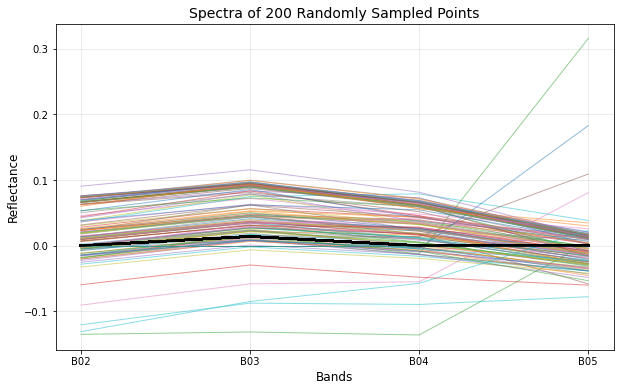

In [7]:
import os
import random
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Paths
input_dir = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\sentinel_glint\glint_model_teste"  # Folder with raster bands
shapefile_path = r"C:\Users\tml411\Documents\teste.shp"  # Shapefile for clipping

# Band definitions
sentinel_bands = ['B02', 'B03', 'B04', 'B05']

# Read shapefile
shape_data = gpd.read_file(shapefile_path)

# Clip and stack bands
stacked_bands = []
profile = None

for band in sentinel_bands:
    # Find the corresponding raster file
    band_file = next(iter([f for f in os.listdir(input_dir) if f"{band}" in f]), None)
    if not band_file:
        raise FileNotFoundError(f"Band {band} file not found in {input_dir}")

    with rasterio.open(os.path.join(input_dir, band_file)) as src:
        
        src_crs = src.crs.to_string()
        shape_data = shape_data.to_crs(src_crs)
        geometries = [feature['geometry'] for feature in shape_data.__geo_interface__['features']]
        
        # Clip the raster to the shapefile geometry
        clipped, transform = mask(src, geometries, crop=True, nodata=0)
        if profile is None:
            profile = src.profile.copy()
            profile.update({
                "height": clipped.shape[1],
                "width": clipped.shape[2],
                "transform": transform,
                "count": len(sentinel_bands)
            })
        stacked_bands.append(clipped[0])  # Add the clipped band to the stack

# Convert stacked bands to array
stacked_array = np.stack(stacked_bands)

# Randomly sample points
rows, cols = np.where(stacked_array[0] < 3)  # Find valid (non-zero) pixels
valid_points = list(zip(rows, cols))

if len(valid_points) < 500:
    raise ValueError("Not enough valid points to sample.")

# Shuffle and select 200 random points
random_points = shuffle(valid_points, n_samples=200, random_state=42)

# Extract and plot spectra
plt.figure(figsize=(10, 6))
for row, col in random_points:
    spectra = stacked_array[:, row, col]  # Extract all bands for the pixel
    plt.plot(sentinel_bands, spectra, alpha=0.5, linewidth=1)  # Plot the spectrum
    # Plot median spectra
    plt.plot(sentinel_bands, np.median(stacked_array, axis=(1, 2)), color='black', linewidth=2)

# Customize the plot
plt.title("Spectra of 200 Randomly Sampled Points", fontsize=14)
plt.xlabel("Bands", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.xticks(range(len(sentinel_bands)), sentinel_bands)  # Set band names on x-axis
plt.grid(alpha=0.3)
plt.show()


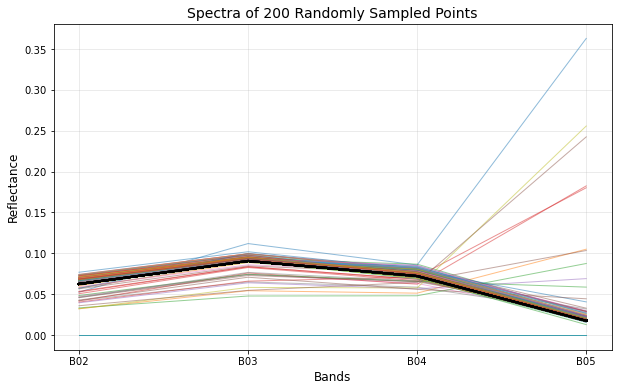

In [90]:
import os
import random
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Paths
input_dir = r"Z:\guser\tml\mypapers\HLS_package_paper\glint_correction\hls_output\landsat_no_glint\hlswater\13QGC\HLS.T13QGC.20230206T02T1B2.TIF.L30.v1.0"  # Folder with raster bands
shapefile_path = r"C:\Users\tml411\Documents\teste.shp"  # Shapefile for clipping

# Band definitions
sentinel_bands = ['B02', 'B03', 'B04', 'B05']

# Read shapefile
shape_data = gpd.read_file(shapefile_path)


# Clip and stack bands
stacked_bands = []
profile = None

for band in sentinel_bands:
    # Find the corresponding raster file
    band_file = next(iter([f for f in os.listdir(input_dir) if f"{band}.tif" in f]), None)
    if not band_file:
        raise FileNotFoundError(f"Band {band} file not found in {input_dir}")

    with rasterio.open(os.path.join(input_dir, band_file)) as src:
        
        src_crs = src.crs.to_string()
        shape_data = shape_data.to_crs(src_crs)
        geometries = [feature['geometry'] for feature in shape_data.__geo_interface__['features']]
        
        # Clip the raster to the shapefile geometry
        clipped, transform = mask(src, geometries, crop=True, nodata=0)
        clipped = clipped/10000
        if profile is None:
            profile = src.profile.copy()
            profile.update({
                "height": clipped.shape[1],
                "width": clipped.shape[2],
                "transform": transform,
                "count": len(sentinel_bands)
            })
        stacked_bands.append(clipped[0])  # Add the clipped band to the stack

# Convert stacked bands to array
stacked_array = np.stack(stacked_bands)

# Randomly sample points
rows, cols = np.where(stacked_array[0] < 3)  # Find valid (non-zero) pixels
valid_points = list(zip(rows, cols))

if len(valid_points) < 500:
    raise ValueError("Not enough valid points to sample.")

# Shuffle and select 200 random points
random_points = shuffle(valid_points, n_samples=200, random_state=42)

# Extract and plot spectra
plt.figure(figsize=(10, 6))
for row, col in random_points:
    spectra = stacked_array[:, row, col]  # Extract all bands for the pixel
    plt.plot(sentinel_bands, spectra, alpha=0.5, linewidth=1)  # Plot the spectrum
    # Plot median spectra
    plt.plot(sentinel_bands, np.median(stacked_array, axis=(1, 2)), color='black', linewidth=2)

# Customize the plot
plt.title("Spectra of 200 Randomly Sampled Points", fontsize=14)
plt.xlabel("Bands", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.xticks(range(len(sentinel_bands)), sentinel_bands)  # Set band names on x-axis
plt.grid(alpha=0.3)
plt.show()
